#**YSDA CV task. Search for N similar images**

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random

from PIL import Image
from torchvision import transforms
from sklearn.neighbors import NearestNeighbors

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [4]:
font = {
    'weight': 'bold',
    'size': 12
}

matplotlib.rc('font', **font)

In [5]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
model.eval()
model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
n_images = 1200
n_neighbors = 5
n_examples = 3
path = "/content/gdrive/MyDrive/machine_learning_practice/datasets/YSDA similar photos/"

In [7]:
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
outputs = []

for i in range(n_images):
    image_name = str(i).zfill(4) + ".png"

    image_path = path + image_name

    input_image = Image.open(image_path)
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    if device == "cuda":
        input_batch = input_batch.to(device)

    with torch.no_grad():
        output = model(input_batch).squeeze()
    
    outputs.append(output)

In [9]:
outputs =  torch.stack(outputs)
outputs = outputs.to("cpu").numpy()

print("outputs shape:", outputs.shape)

outputs shape: (1200, 1000)


In [10]:
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="auto", metric='euclidean').fit(outputs)

In [11]:
_, indices = nbrs.kneighbors(outputs)

print("indices shape:", indices.shape)

indices shape: (1200, 5)


In [12]:
def show_images_row(current_image_name, current_image_path,
                    nbrs_names, nbrs_paths, row_num):
    fig, axes = plt.subplots(ncols = n_neighbors, figsize=(20, 5))
    fig.suptitle(f"Example {row_num}")

    current_image = Image.open(current_image_path)

    axes[0].imshow(current_image)
    axes[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    axes[0].set_title(f"current image,\nimage name: {current_image_name}")

    for nbr_idx, nbrs_path in enumerate(nbrs_paths):
        nbr_image = Image.open(nbrs_path)

        axes[nbr_idx + 1].imshow(nbr_image)
        axes[nbr_idx + 1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        axes[nbr_idx + 1].set_title(f"neighbor {nbr_idx + 1},\nimage name: {nbrs_names[nbr_idx]}")
    
    plt.show()
    
    print("\n")

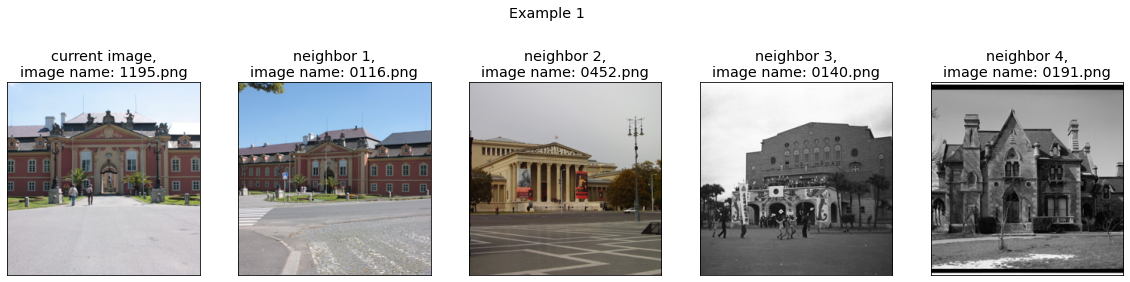

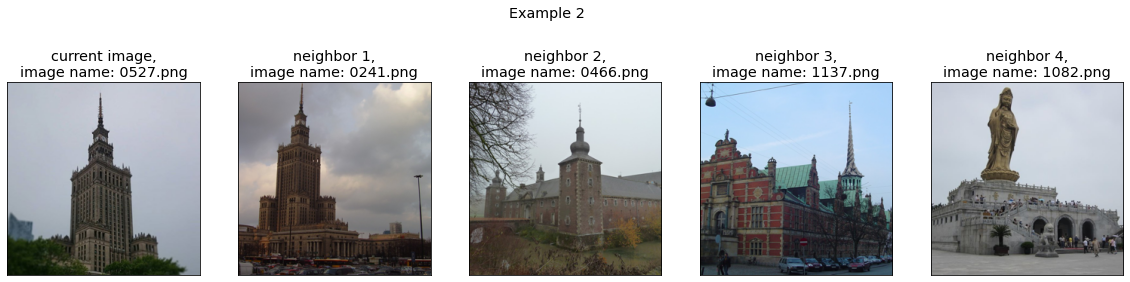

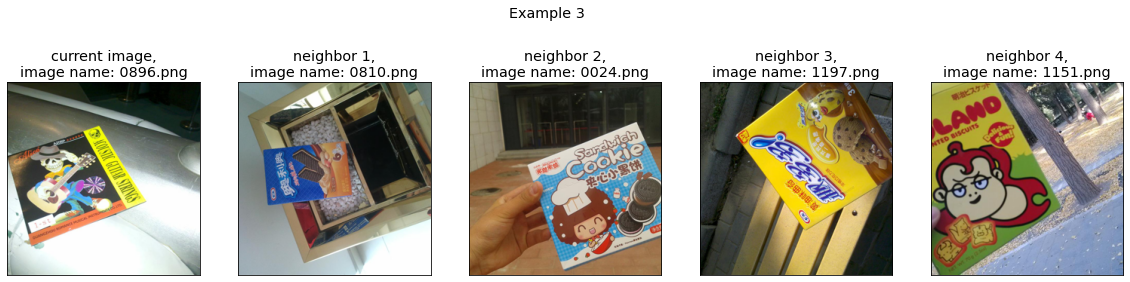

In [13]:
for i in range(n_examples):
    image_idx = random.randint(0, n_images)

    current_image_name = str(image_idx).zfill(4) + ".png"
    current_image_path = path + current_image_name

    nbrs_names = [str(idx).zfill(4) + ".png" for idx in indices[image_idx][1:]]
    nbrs_paths = [path + nbr_name for nbr_name in nbrs_names]

    show_images_row(current_image_name, current_image_path,
                    nbrs_names, nbrs_paths, i + 1)